In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder

# 30개의 Feature 할당
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()

# class [B, M]을 class [0, 1]로 전환
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

In [4]:
# Train Data와 Test Data에서의 모형의 성능이
# 최소한 0.63 이상이 되어야 모형의 기능을 할 수 있다는 것을 의미

# 특성변수를 전혀 사용하지 않고 어떤 자료가 있든 관계없이
# y를 0으로 무조건 분류하면 약 63%의 정밀도를 보이기 때문.

print(1 - y.mean())

0.6274165202108963


In [5]:
# Data Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [7]:
# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(random_state=1)) # 적용 순서대로 나열
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [8]:
y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)

In [9]:
# Accuracy Score
pipe_lr.score(X_train, y_train)

0.967032967032967

In [10]:
pipe_lr.score(X_test, y_test)

0.956140350877193

In [11]:
# k-분할 교차검증
# 각 분할의 클래스 비율이 전체 클래스 비율과 동일하도록 층화 k-분할 교차검증을 제공 (Stratified k-fold cross-validation)

from sklearn.model_selection import cross_val_score

# 10개의 분할(k=10)로 구성된 교차검증
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.97826087 0.95652174 0.95652174 0.95652174 0.91304348 0.95555556
 0.97777778 0.97777778 1.         0.97777778]


In [13]:
# 10개의 Val Data로부터 구한 10개의 정밀도 및 이 정밀도의 평균과 표준편차 계산

import numpy as np
print('CV accuracy scores: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: 0.965 +/- 0.022


In [16]:
# 모형진단을 위한 편의와 분산을 산출
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [17]:
print(train_mean)

[1.         1.         0.99344262 0.99754601 0.99166667 0.98571429
 0.98601399 0.98746177 0.9888587  0.98924205]


In [18]:
print(train_std)

[0.         0.         0.00327869 0.00300551 0.00441176 0.00329072
 0.00312737 0.00214067 0.00146336 0.00119779]


In [19]:
print(test_mean)

[0.94531401 0.95381643 0.96048309 0.97149758 0.96927536 0.97144928
 0.9736715  0.97797101 0.98241546 0.98024155]


In [20]:
print(test_std)

[0.04147213 0.02306853 0.02567195 0.01396127 0.0145413  0.00998832
 0.00857743 0.01390465 0.01645096 0.02063368]


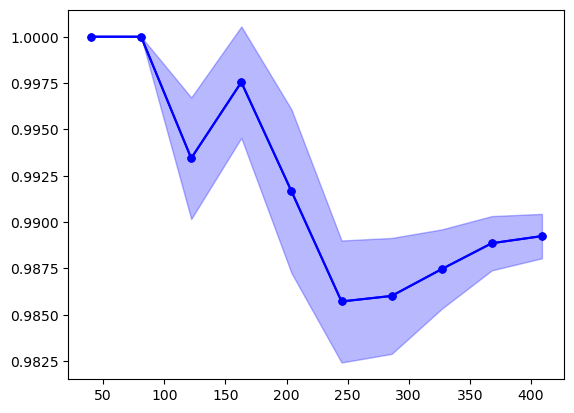

In [22]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.show()

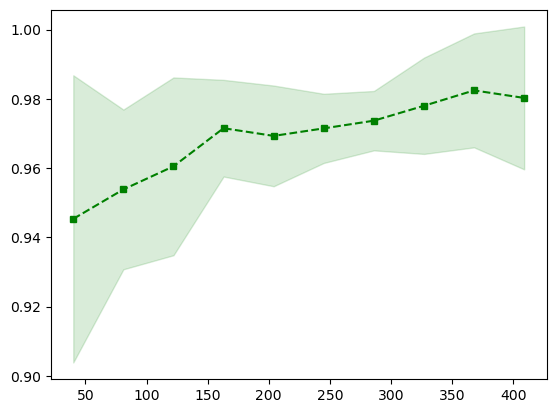

In [23]:
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.show()

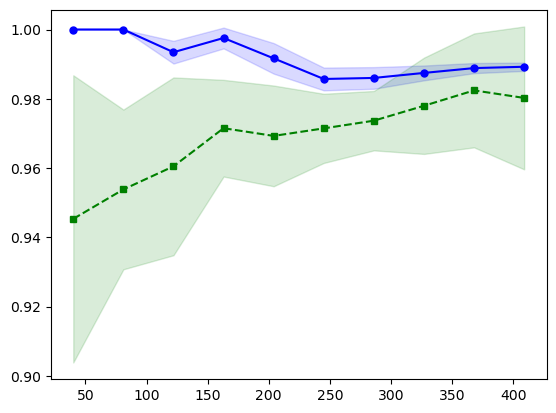

In [24]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.show()

In [25]:
# 초모수의 결정
# GridSearch에 의해 구한다. GridSearchCV() 함수

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                 scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)

0.9846859903381642


In [26]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [27]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9736842105263158

In [28]:
# SVM

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=3)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.979 +/- 0.007


In [30]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy', cv=3)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.916 +/- 0.022


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy', cv=inner_cv)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.944 +/- 0.012


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

inner_cv = KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy', cv=inner_cv)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.944 +/- 0.012


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy', cv=inner_cv)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.928 +/- 0.024
